# 📉 Financial Tick Data Storage with Chronostore

In [9]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from chronostore import TimeSeriesEngine, TableSchema, ColumnSchema
from chronostore.backend import FlatFileBackend
import os

# Clean existing data
os.system("rm -rf ./data")

# Define schema for tick data
schema = TableSchema(columns=[
    ColumnSchema("timestamp", "q"),     # int64 nanoseconds
    ColumnSchema("price", "d"),         # float64
    ColumnSchema("size", "q"),          # int64
    ColumnSchema("is_buy", "?"),        # bool (1-byte)
])

# Setup engine
backend = FlatFileBackend(schema, "./data")
engine = TimeSeriesEngine(backend)

# Simulate 100k ticks across 1 trading day
num_ticks = 100_000
price = 100.00
prices = np.zeros(num_ticks, dtype=np.float64)
sizes = np.random.choice([1, 2, 3, 4, 5, 10, 50], p=[0.4, 0.2, 0.15, 0.1, 0.1, 0.04, 0.01], size=num_ticks)
is_buy = np.random.choice([True, False], size=num_ticks)

for i in range(num_ticks):
    price += np.random.choice([-0.01, 0, 0.01], p=[0.45, 0.1, 0.45])
    prices[i] = price

start_time = datetime(2025, 9, 6, 9, 30)
ts_array = np.array([
    int((start_time + timedelta(microseconds=i * 1000)).timestamp() * 1e9)
    for i in range(num_ticks)
], dtype=np.int64)

df = pd.DataFrame({
    "timestamp": ts_array,
    "price": prices,
    "size": sizes,
    "is_buy": is_buy,
})

# Append in batch to Chronostore
engine.append("AAPL", "2025-09-06", df)
engine.flush()

print(f"✅ Appended {num_ticks:,} ticks.")

# Read full tick data
ticks = engine.read("AAPL", "2025-09-06")
print(f"✅ Read {len(ticks['timestamp']):,} ticks")

# Filter large trades (size >= 8)
large_trades = engine.read("AAPL", "2025-09-06", where=lambda d: d["size"] > 9)
print(f"Large trades: {len(large_trades['timestamp'])}")

✅ Appended 100,000 ticks.
✅ Read 100,000 ticks
Large trades: 5104


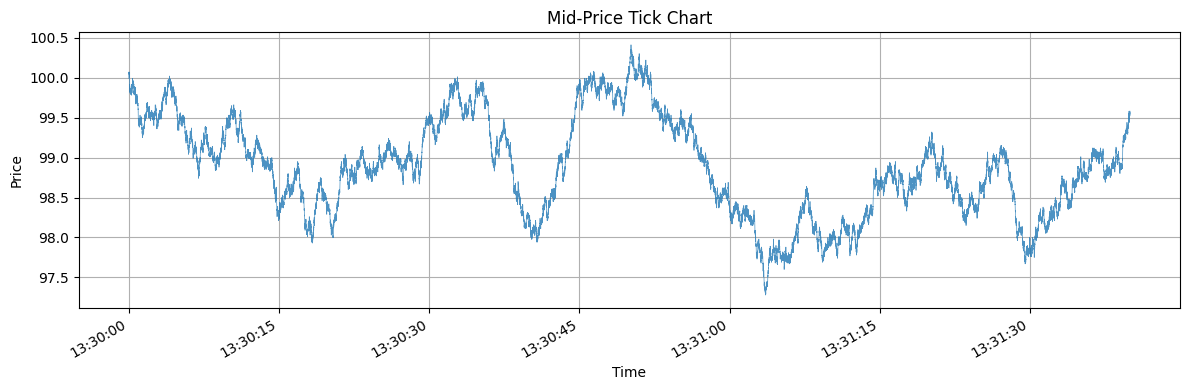

In [13]:
ts = pd.to_datetime(ticks["timestamp"], unit="ns")
df_ticks = pd.DataFrame({
    "timestamp": ts,
    "price": ticks["price"],
    "size": ticks["size"],
    "is_buy": ticks["is_buy"],
})
df_ticks.set_index("timestamp", inplace=True)

# Mid-price line plot
plt.figure(figsize=(12, 4))
df_ticks["price"].plot(alpha=0.8, lw=0.5)
plt.title("Mid-Price Tick Chart")
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()